# Antibody escape in natural sequences

This notebook is a copy of the original natural_sequence_antibody_escape.ipynb with an additional section to produce eps figures for Figure 5A of the manuscript. This analysis was performed on Dec 7, 2024.

In [1]:
# Imports
import os
import yaml
import warnings
import scipy as sp
import pandas as pd
import altair as alt
from Bio import SeqIO, AlignIO 

# Suppress warnings
warnings.simplefilter("ignore")

# Allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

In [2]:
# this cell is tagged as `parameters` for papermill parameterization
filtered_antibody_csv = None
site_map_csv = None

sequence_metadata = None
sequence_alignment = None

natural_diversity_outdir = None
mutation_count_csv = None
antibody_escape_vs_nature_html = None

In [3]:
# # Uncomment for running interactive
filtered_antibody_csv = "../results/summaries/all_antibodies_and_cell_entry_per_antibody_escape.csv"
site_map_csv = "../data/site_numbering_map.csv"

sequence_metadata = "../non-pipeline_analyses/RABV_nextstrain/Results/G/metadata.tsv"
sequence_alignment = "../non-pipeline_analyses/RABV_nextstrain/Results/G/Alignments/protein_ungapped_no_outgroup.fasta"

natural_diversity_outdir = "../results/natural_diversity_comparison/"
mutation_count_csv = "../results/natural_diversity_comparison/mutation_counts.csv"
antibody_escape_vs_nature_html = "../results/natural_diversity_comparison/antibody_escape_vs_natural_diversity.html"

Create a dataframe for amino acid level measurements and mutational frequencies with respect to the reference strain calculated from natural sequence alignments. 

In [4]:
def get_natural_sequence_counts(site, amino_acid, natural_seqs_df):
    """
    Function that counts occurences of an amino acid at a site
    across a dataframe of sequences.
    """
    count = 0
    for seq in natural_seqs_df["sequence"].tolist():
        if seq[site-1] == amino_acid:
            count += 1
    return count

# Load alignment and metadata info
natural_seqs_df = pd.DataFrame(columns=["strain", "sequence"])
metadata_df = pd.read_csv(sequence_metadata, sep="\t")

# Add alignment sequence to dataframe
for curr_fasta in AlignIO.read(sequence_alignment, "fasta"):
    natural_seqs_df.loc[len(natural_seqs_df.index)] = [
        str(curr_fasta.id),
        str(curr_fasta.seq),
    ] 

# Merge sequences and metadata
natural_seqs_df = (
    metadata_df.merge(
        natural_seqs_df,
        how="right",
        on=["strain"],
        validate="one_to_one",
    )
)

# Get Reference sequence for comparison
ref_sequence = natural_seqs_df.loc[natural_seqs_df["strain"] == "NC_001542_2018-08-13"].reset_index().at[0,"sequence"]

# Filter for only non-lab based sequences
natural_seqs_df = (
    natural_seqs_df
    .query("host not in ['Lab based', '?'] & sequence.notna()")
    .reset_index(drop=True)
)


# Initialize mutant dataframe
mutation_count_df = pd.DataFrame(columns=["natural_sequence_site", "wildtype", "mutant"])
for i in range(len(ref_sequence)):
    site_list = [i+1] * 20
    wt_list = [ref_sequence[i]] * 20
    mutation_count_df = pd.concat([
        mutation_count_df,
        pd.DataFrame({
            "natural_sequence_site" : site_list, 
            "wildtype" : wt_list,
            "mutant" : ['R','K','H','D','E','Q','N','S','T','Y','W','F','A','I','L','M','V','G','P','C'],
        })
    ])
mutation_count_df["DMS reference"] = (
    mutation_count_df.apply(lambda x: True if x["wildtype"] == x["mutant"] else False, axis=1)
)

# Get natural sequence counts of each mutant and calculate mutation frequencies
# compared to the  reference
mutation_count_df["natural_counts"] = (
    mutation_count_df.apply(lambda x: get_natural_sequence_counts(x["natural_sequence_site"], x["mutant"], natural_seqs_df), axis=1)
)
number_sequences = mutation_count_df["natural_counts"].max()
mutation_count_df["mutation_frequency"] = (
    mutation_count_df.apply(lambda x: x["natural_counts"]/number_sequences if x["DMS reference"] == False else None, axis=1)
)

antibodies = [
    "RVC20",
    "RVA122",
    "17C7",
    "RVC58",
    "CR4098",
    "CR57",
    "CTB012",
    "RVC68",
]

# Add escape to dataframe for each antibody
for i,antibody in enumerate(antibodies):

    # Load data as dataframe
    escape_df = pd.read_csv(filtered_antibody_csv)

    # Load site map and merge with escape_df
    site_map = (
        pd.read_csv(site_map_csv)
        .rename(columns={
            "reference_site" : "site",
            "reference_wt" : "wildtype",
        })
    )
    escape_df = (
        escape_df.merge(
            site_map,
            how="left",
            on=["site", "wildtype"],
            validate="many_to_one",
        )
    )

    # Create natural sequence mutation col
    escape_df["natural_sequence_mutation"] = (
        escape_df["wildtype"] + escape_df["natural_sequence_site"].astype(str) + escape_df["mutant"]
    )

    # Floor escape and extract single antibody data
    escape_df["floored_escape"] = escape_df["escape"].clip(lower=0)
    escape_df = escape_df.query("antibody == @antibody")
    
    # Rename escape column to include antibody name
    escape_df = escape_df.rename(columns={"floored_escape" : "floored_escape_" + antibody})

    # Merge dataframes
    if i == 0:
        mutation_count_df = (
            mutation_count_df.merge(
                escape_df[["natural_sequence_site", "site", "sequential_site", "wildtype", "mutant", "floored_escape_" + antibody]],
                how="left",
                on=["natural_sequence_site", "wildtype", "mutant"],
                validate="one_to_one",
            )
        )
    else:
        mutation_count_df = (
            mutation_count_df.merge(
                escape_df[["natural_sequence_site", "wildtype", "mutant", "floored_escape_" + antibody]],
                how="left",
                on=["natural_sequence_site", "wildtype", "mutant"],
                validate="one_to_one",
            )
        )
min_sequences = 2
total_sequences = mutation_count_df["natural_counts"].max()
cutoff = min_sequences / total_sequences
cutoff_truncated = float(str(cutoff)[0:6]) - 0.00005
print(f"Min sequences: {min_sequences}")
print(f"Total sequenes: {total_sequences}")
print(f"Mutational frequency cutoff: {cutoff}")

# Mark mutations above frequency cutoff
mutation_count_df["greater_than_cutoff"] = (
    mutation_count_df["mutation_frequency"].apply(lambda x: True if x >= cutoff else False)
)

# Make output dir if doesn't exist
if not os.path.exists(natural_diversity_outdir):
    os.mkdir(natural_diversity_outdir)

# Save CSV file
mutation_count_df.to_csv(mutation_count_csv, index=False)

Min sequences: 2
Total sequenes: 6581
Mutational frequency cutoff: 0.000303905181583346


In [5]:
# Replace 0 with small value to display on log scale so that all DMS measured mutations appear at far left of plot
mutation_count_df["mutation_frequency"] = mutation_count_df["mutation_frequency"].replace(0, 0.00001) # smallest value ~0.0001

selection_mutation = alt.selection_point(on="mouseover", empty=False, fields=["site", "mutant"])

subplots = []
for antibody in antibodies:

    curr_subplot = alt.Chart(mutation_count_df, title=antibody).mark_point(
        filled=True, 
        color="black", 
        size=75,
        opacity=0.15,
        stroke="black",
    ).encode(
        alt.X(
            "mutation_frequency",
            axis=alt.Axis(
                title="mutation frequency", 
                # values=[0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1],
                domainWidth=1,
                domainColor="black",
                tickColor="black",
                # format="0.3",
            ),
            scale=alt.Scale(type="log")
        ),
        alt.Y(
            "floored_escape_" + antibody,
            axis=alt.Axis(
                title="escape", 
                # values=[0,1,2,3,4,5,6],
                domainWidth=1,
                domainColor="black",
                tickColor="black",
            ),
            # scale=alt.Scale(domain=[0,6.1])
        ),
        tooltip=[
            "site", 
            "sequential_site",
            "natural_sequence_site",
            "wildtype",
            "mutant",
            alt.Tooltip(
                "mutation_frequency", format=".3g"
            ),
            alt.Tooltip(
            "floored_escape_" + antibody, format=".3g"
            ),
        ],
        opacity=alt.condition(selection_mutation, alt.value(1), alt.value(0.15)),
        color=alt.condition(selection_mutation, alt.value("orange"), alt.value("black")),
        size=alt.condition(selection_mutation, alt.value(85), alt.value(75)),
        strokeWidth=alt.condition(selection_mutation, alt.value(1.5), alt.value(0)),
    ).properties(
        width=250,
        height=150,
    ).add_selection(
        selection_mutation
    )

    cutoff = alt.Chart(pd.DataFrame({'x':[cutoff_truncated]})).mark_rule(color="black", size=1, strokeDash=[8,8]).encode(x="x")
    curr_subplot = curr_subplot + cutoff
    
    subplots.append(curr_subplot)

row_1 = alt.hconcat(
    subplots[0],
    subplots[1],
    subplots[2],
    subplots[3],  
    spacing=10,
)

row_2 = alt.hconcat(
    subplots[4],
    subplots[5],
    subplots[6],
    subplots[7],  
    spacing=10,
)

natural_vs_antibody = alt.vconcat(
    row_1,
    row_2,
    spacing=10,
    title=["Mutational frequencies vs antibody escape", "for individual amino-acid mutations"],
).configure_axis(
    grid=False,
    labelFontSize=16,
    titleFontSize=16,
    labelFontWeight="normal",
    titleFontWeight="normal",
).configure_title(
    fontSize=24,
)

# Make output dir if doesn't exist
if not os.path.exists(natural_diversity_outdir):
    os.mkdir(natural_diversity_outdir)

print(f"Saving to {antibody_escape_vs_nature_html}")
natural_vs_antibody.save(antibody_escape_vs_nature_html)

natural_vs_antibody

Saving to ../results/natural_diversity_comparison/antibody_escape_vs_natural_diversity.html


alt.VConcatChart(...)

In [6]:
mutation_count_df

natural_sequence_site wildtype mutant  DMS reference  natural_counts  \
0                         1        M      R          False               0   
1                         1        M      K          False               0   
2                         1        M      H          False               0   
3                         1        M      D          False               0   
4                         1        M      E          False               0   
...                     ...      ...    ...            ...             ...   
10475                   524        L      M          False              43   
10476                   524        L      V          False               1   
10477                   524        L      G          False               0   
10478                   524        L      P          False               1   
10479                   524        L      C          False               0   

       mutation_frequency  site  sequential_site  floored_escape_RVC20  \
0                0.000010   NaN              NaN                   NaN   
1                0.000010   NaN              NaN                   NaN   
2                0.000010   NaN              NaN                   NaN   
3                0.000010   NaN              NaN                   NaN   
4                0.000010   NaN              NaN                   NaN   
...                   ...   ...              ...                   ...   
10475            0.006534   NaN              NaN                   NaN   
10476            0.000152   NaN              NaN                   NaN   
10477            0.000010   NaN              NaN                   NaN   
10478            0.000152   NaN              NaN                   NaN   
10479            0.000010   NaN              NaN                   NaN   

       floored_escape_RVA122  floored_escape_17C7  floored_escape_RVC58  \
0                        NaN                  NaN                   NaN   
1                        NaN                  NaN                   NaN   
2                        NaN                  NaN                   NaN   
3                        NaN                  NaN                   NaN   
4                        NaN                  NaN                   NaN   
...                      ...                  ...                   ...   
10475                    NaN                  NaN                   NaN   
10476                    NaN                  NaN                   NaN   
10477                    NaN                  NaN                   NaN   
10478                    NaN                  NaN                   NaN   
10479                    NaN                  NaN                   NaN   

       floored_escape_CR4098  floored_escape_CR57  floored_escape_CTB012  \
0                        NaN                  NaN                    NaN   
1                        NaN                  NaN                    NaN   
2                        NaN                  NaN                    NaN   
3                        NaN                  NaN                    NaN   
4                        NaN                  NaN                    NaN   
...                      ...                  ...                    ...   
10475                    NaN                  NaN                    NaN   
10476                    NaN                  NaN                    NaN   
10477                    NaN                  NaN                    NaN   
10478                    NaN                  NaN                    NaN   
10479                    NaN                  NaN                    NaN   

       floored_escape_RVC68  greater_than_cutoff  
0                       NaN                False  
1                       NaN                False  
2                       NaN                False  
3                       NaN                False  
4                       NaN                False  
...                     ...                  ...  
10475    

## Plot figures for paper (Figure 5A)

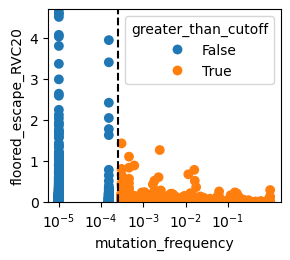

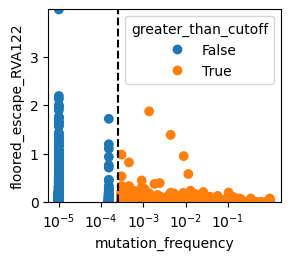

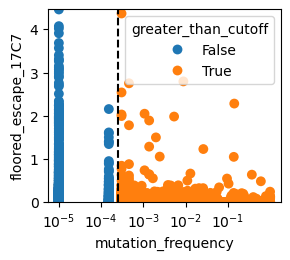

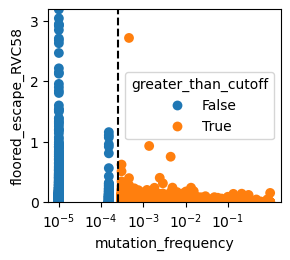

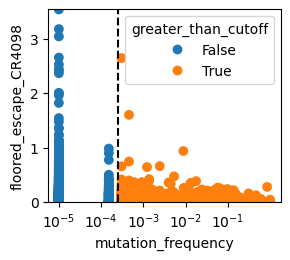

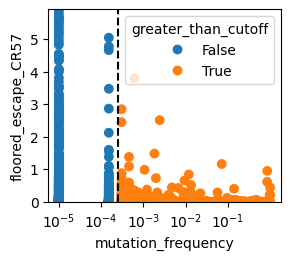

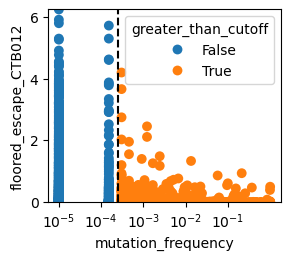

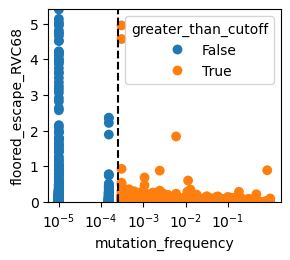

In [7]:
import seaborn as sb
from matplotlib import pyplot as pl


for i in antibodies: 
    y_axis = 'floored_escape_'+i;
    fig, ax= pl.subplots(figsize=(3,2.5))
    sb.scatterplot(data=mutation_count_df,x='mutation_frequency',y=y_axis,hue='greater_than_cutoff',s=50,edgecolor="none")
    pl.plot([cutoff_truncated,cutoff_truncated],[0,mutation_count_df[y_axis].max()],'k--');
    pl.ylim([0,mutation_count_df[y_axis].max()])
    pl.xscale('log')
    pl.xticks(ticks=[10**-5,10**-4,10**-3,10**-2,10**-1])
    # file_name = i+'_escape-vs-frequency.eps';
    # fig.savefig(file_name);

## Create dataframe of mutations relative to DMS strain for every natural strain

In [8]:
# Load alignment and metadata info
natural_seqs_df = pd.DataFrame(columns=["strain", "sequence"])
metadata_df = pd.read_csv(sequence_metadata, sep="\t")

# Add alignment sequence to dataframe
for curr_fasta in AlignIO.read(sequence_alignment, "fasta"):
    natural_seqs_df.loc[len(natural_seqs_df.index)] = [
        str(curr_fasta.id),
        str(curr_fasta.seq),
    ] 

# Merge sequences and metadata
natural_seqs_df = (
    metadata_df.merge(
        natural_seqs_df,
        how="right",
        on=["strain"],
        validate="one_to_one",
    )
)

# Get Reference sequence for comparison
ref_sequence = natural_seqs_df.loc[natural_seqs_df["strain"] == "NC_001542_2018-08-13"].reset_index().at[0,"sequence"]

def get_mutations(ref, seq):
    """
    Function that gets all mutations relative to the DMS strain.
    """
    mutations = []
    for index,AA in enumerate(ref):
        if AA != seq[index] and seq[index] != "-":
            mutations.append(AA + str(index+1) + seq[index])
    return mutations

natural_seqs_df["mutations_relative_to_DMS_strain"] = (
    natural_seqs_df.apply(lambda x: get_mutations(ref_sequence, x["sequence"]), axis=1)
)

natural_seqs_df = natural_seqs_df.explode("mutations_relative_to_DMS_strain")

natural_seqs_df

strain              virus phylogroup  \
0                      NC_001542_2018-08-13  Rabies lyssavirus          I   
1     CENASA-MX23-Rab24_PQ379828_2023-05-29  Rabies lyssavirus          I   
1     CENASA-MX23-Rab24_PQ379828_2023-05-29  Rabies lyssavirus          I   
1     CENASA-MX23-Rab24_PQ379828_2023-05-29  Rabies lyssavirus          I   
1     CENASA-MX23-Rab24_PQ379828_2023-05-29  Rabies lyssavirus          I   
...                                     ...                ...        ...   
7121                Flury_X69122_1992-12-03  Rabies lyssavirus          I   
7121                Flury_X69122_1992-12-03  Rabies lyssavirus          I   
7121                Flury_X69122_1992-12-03  Rabies lyssavirus          I   
7121                Flury_X69122_1992-12-03  Rabies lyssavirus          I   
7121                Flury_X69122_1992-12-03  Rabies lyssavirus          I   

     gene host  accession        date location         region country  \
0       G    ?  NC_001542  2018-08-13        ?              ?       ?   
1       G    ?   PQ379828  2023-05-29   Mexico  North America  Mexico   
1       G    ?   PQ379828  2023-05-29   Mexico  North America  Mexico   
1       G    ?   PQ379828  2023-05-29   Mexico  North America  Mexico   
1       G    ?   PQ379828  2023-05-29   Mexico  North America  Mexico   
...   ...  ...        ...         ...      ...            ...     ...   
7121    G    ?     X69122  1992-12-03        ?              ?       ?   
7121    G    ?     X69122  1992-12-03        ?              ?       ?   
7121    G    ?     X69122  1992-12-03        ?              ?       ?   
7121    G    ?     X69122  1992-12-03        ?              ?       ?   
7121    G    ?     X69122  1992-12-03        ?              ?       ?   

                     database              authors  \
0     BioProject: PRJNA485481          Tordo et al   
1                           ?     Mora-Palma et al   
1                           ?     Mora-Palma et al   
1                           ?     Mora-Palma et al   
1                           ?     Mora-Palma et al   
...                       ...                  ...   
7121                        ?  Chandrasekhar et al   
7121                        ?  Chandrasekhar et al   
7121                        ?  Chandrasekhar et al   
7121                        ?  Chandrasekhar et al   
7121                        ?  Chandrasekhar et al   

                                                 url  \
0     https://www.ncbi.nlm.nih.gov/nuccore/NC_001542   
1      https://www.ncbi.nlm.nih.gov/nuccore/PQ379828   
1      https://www.ncbi.nlm.nih.gov/nuccore/PQ379828   
1      https://www.ncbi.nlm.nih.gov/nuccore/PQ379828   
1      https://www.ncbi.nlm.nih.gov/nuccore/PQ379828   
...                                              ...   
7121     https://www.ncbi.nlm.nih.gov/nuccore/X69122   
7121     https://www.ncbi.nlm.nih.gov/nuccore/X69122   
7121     https://www.ncbi.nlm.nih.gov/nuccore/X69122   
7121     https://www.ncbi.nlm.nih.gov/nuccore/X69122   
7121     https://www.ncbi.nlm.nih.gov/nuccore/X69122   

                                                  title  \
0     Completion of the rabies virus genome sequence...   
1                                     Direct Submission   
1                                     Direct Submission   
1                                     Direct Submission   
1                                     Direct Submission   
...                                                 ...   
7121                                                  ?   
7121                                                  ?   
7121                                                  ?   
7121                                                  ?   
7121                                                  ?   

                                                journal  \
0                      Virology 165 (2), 565-576 (1988)   
1     Submitted (17-SEP-2024) CENASA, SENASICA, Carr...   
1     Submitted (17-SEP-202

## Get top escape mutations for strains and antibodies (Figure 5C)

In [47]:
strains = 'A12_2718_KC792123_2012-01-01';

In [48]:
Strain_Subet = natural_seqs_df[natural_seqs_df['strain']==strains]

#okay this'll take some formatting to produce a list. We need to correct the sequence numbering.

Strain_Subet['site'] = Strain_Subet['mutations_relative_to_DMS_strain'].apply(lambda x: int(x[1:-1]));
Strain_Subet['site_ectodomain'] = Strain_Subet['site'].apply(lambda x: x-19);


Strain_Subet['native'] = Strain_Subet['mutations_relative_to_DMS_strain'].apply(lambda x: x[0]);
Strain_Subet['mutant'] = Strain_Subet['mutations_relative_to_DMS_strain'].apply(lambda x: x[-1]);

#sites <0 are outside of ectodomain
Strain_Subet=Strain_Subet[Strain_Subet['site_ectodomain']>1];
Strain_Subet=Strain_Subet[Strain_Subet['site_ectodomain']<433];

#let's also go ahead and make a corrected mutant notation

Strain_Subet['site_ectodomain_str'] = Strain_Subet['site_ectodomain'].apply(lambda x: str(x));

Strain_Subet['mutations_ectodomain_corrected']=Strain_Subet['native']+Strain_Subet['site_ectodomain_str']+Strain_Subet['mutant'];



In [49]:
#pull in escape data

all_escapes = pd.read_csv(filtered_antibody_csv);
all_escapes['site_str']=all_escapes['site'].apply(lambda x: str(x));

all_escapes['mutations_ectodomain_corrected'] = all_escapes['wildtype'] + all_escapes['site_str'] + all_escapes['mutant'];


#pull in antibody escape
CR4098_data = all_escapes[all_escapes['antibody']=='CR4098'];
RVC58_data = all_escapes[all_escapes['antibody']=='RVC58'];
Rabishield_data = all_escapes[all_escapes['antibody']=='17C7'];

#merge. Note Rabishield is 17C7--I just used Rabishield in the code for ease.
CR4098_data_merged = pd.merge(Strain_Subet,CR4098_data,how='inner',on=['mutations_ectodomain_corrected']);
CR4098_data_merged = CR4098_data_merged.sort_values(by='escape',ascending=False)

RVC58_data_merged = pd.merge(Strain_Subet,RVC58_data,how='inner',on=['mutations_ectodomain_corrected']);
RVC58_data_merged = RVC58_data_merged.sort_values(by='escape',ascending=False)

Rabishield_data_merged = pd.merge(Strain_Subet,Rabishield_data,how='inner',on=['mutations_ectodomain_corrected']);
Rabishield_data_merged = Rabishield_data_merged.sort_values(by='escape',ascending=False)

In [50]:
Rabishield_data_merged[['mutations_ectodomain_corrected','escape']].head(5)

mutations_ectodomain_corrected  escape
28                          I338T  4.3690
29                          R346S  1.9800
2                            M44I  1.0520
21                          P253S  0.6333
18                          M243I  0.4799

In [51]:
RVC58_data_merged[['mutations_ectodomain_corrected','escape']].head(5)

mutations_ectodomain_corrected  escape
28                          I338T  0.5081
2                            M44I  0.4000
9                           A163T  0.1499
29                          R346S  0.1471
26                          M291V  0.1406

In [52]:
strains = 'NY-2011-1202O_MK540766_2011-XX-XX' 

In [53]:
Strain_Subet = natural_seqs_df[natural_seqs_df['strain']==strains]

#okay this'll take some formatting to produce a list. We need to correct the sequence numbering.

Strain_Subet['site'] = Strain_Subet['mutations_relative_to_DMS_strain'].apply(lambda x: int(x[1:-1]));
Strain_Subet['site_ectodomain'] = Strain_Subet['site'].apply(lambda x: x-19);


Strain_Subet['native'] = Strain_Subet['mutations_relative_to_DMS_strain'].apply(lambda x: x[0]);
Strain_Subet['mutant'] = Strain_Subet['mutations_relative_to_DMS_strain'].apply(lambda x: x[-1]);

#sites <0 are outside of ectodomain
Strain_Subet=Strain_Subet[Strain_Subet['site_ectodomain']>1];
Strain_Subet=Strain_Subet[Strain_Subet['site_ectodomain']<433];

#let's also go ahead and make a corrected mutant notation

Strain_Subet['site_ectodomain_str'] = Strain_Subet['site_ectodomain'].apply(lambda x: str(x));

Strain_Subet['mutations_ectodomain_corrected']=Strain_Subet['native']+Strain_Subet['site_ectodomain_str']+Strain_Subet['mutant'];


In [54]:
#pull in escape data

all_escapes = pd.read_csv(filtered_antibody_csv);
all_escapes['site_str']=all_escapes['site'].apply(lambda x: str(x));

all_escapes['mutations_ectodomain_corrected'] = all_escapes['wildtype'] + all_escapes['site_str'] + all_escapes['mutant'];


#pull in antibody escape
CR4098_data = all_escapes[all_escapes['antibody']=='CR4098'];
RVC58_data = all_escapes[all_escapes['antibody']=='RVC58'];
Rabishield_data = all_escapes[all_escapes['antibody']=='17C7'];

#merge. Note Rabishield is 17C7--I just used Rabishield in the code for ease.
CR4098_data_merged = pd.merge(Strain_Subet,CR4098_data,how='inner',on=['mutations_ectodomain_corrected']);
CR4098_data_merged = CR4098_data_merged.sort_values(by='escape',ascending=False)

Rabishield_data_merged = pd.merge(Strain_Subet,Rabishield_data,how='inner',on=['mutations_ectodomain_corrected']);
Rabishield_data_merged = Rabishield_data_merged.sort_values(by='escape',ascending=False)

In [55]:
Rabishield_data_merged[['mutations_ectodomain_corrected','escape']].head(5)

mutations_ectodomain_corrected  escape
29                          R346K  2.2810
28                          N336S  1.0460
23                          P253S  0.6333
20                          M243I  0.4799
24                          G255D  0.2390

In [56]:
CR4098_data_merged[['mutations_ectodomain_corrected','escape']].head(5)

mutations_ectodomain_corrected  escape
21                          S246L  0.2165
3                            T90M  0.1567
10                          V162L  0.1486
25                          R264H  0.1231
26                          I268L  0.1214